In [ ]:
# Colab Setup
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore")

# 1. Load Iris dataset
iris = load_iris(as_frame=True)
X = iris.data
y = iris.target  # labels: 0=setosa, 1=versicolor, 2=virginica
feature_names = iris.feature_names
target_names = iris.target_names
print("Loaded Iris: features:", feature_names, " | target classes:", target_names)

# Utility function for splitting and evaluating
def do_split_and_regression(split_name, train_ratio, val_ratio, test_ratio):
    # Stratified splits
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=(1 - train_ratio), stratify=y, random_state=42)
    # Split temp into val & test
    val_frac = val_ratio / (val_ratio + test_ratio)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(1 - val_frac), stratify=y_temp, random_state=42)

    print(f"\nSplit: {split_name} (Train:Val:Test = {train_ratio*100:.0f}:{val_ratio*100:.0f}:{test_ratio*100:.0f})")
    print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

    # Train Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # Predict and round
    for phase, X_p, y_p in [("Validation", X_val, y_val), ("Test", X_test, y_test)]:
        y_pred_cont = lr.predict(X_p)
        y_pred = np.clip(np.round(y_pred_cont).astype(int), 0, 2)
        acc = accuracy_score(y_p, y_pred)
        print(f"\n{phase} Results:")
        print(" Rounded Predictions Accuracy:", acc)
        print(classification_report(y_p, y_pred, target_names=target_names, zero_division=0))

# Run for both split settings
do_split_and_regression("80:10:10", 0.80, 0.10, 0.10)
do_split_and_regression("70:15:15", 0.70, 0.15, 0.15)


Loaded Iris: features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']  | target classes: ['setosa' 'versicolor' 'virginica']

Split: 80:10:10 (Train:Val:Test = 80:10:10)
Shapes: (120, 4) (15, 4) (15, 4)

Validation Results:
 Rounded Predictions Accuracy: 1.0
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00         5
  versicolor       1.00      1.00      1.00         5
   virginica       1.00      1.00      1.00         5

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15


Test Results:
 Rounded Predictions Accuracy: 1.0
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00         5
  versicolor       1.00      1.00      1.00         5
   virginica       1.00      1.00      1.00         5

    accuracy                           1.00        15
  

less exposure to class boundaries

With 120 training samples, the model sees enough variety to generalize well.

Majority class size: 80, Minority class size: 40
Number of minority samples needed to balance: 40
Majority class size: 80, Minority class size: 40
Number of minority samples needed to balance: 40
Majority class size: 80, Minority class size: 40
Number of minority samples needed to balance: 40
Majority class size: 70, Minority class size: 35
Number of minority samples needed to balance: 35
Majority class size: 70, Minority class size: 35
Number of minority samples needed to balance: 35
Majority class size: 70, Minority class size: 35
Number of minority samples needed to balance: 35

=== Oversampled Results for 80:10:10 split ===
Class setosa: Validation Acc = 100.00%, Test Acc = 100.00%
Class versicolor: Validation Acc = 66.67%, Test Acc = 80.00%
Class virginica: Validation Acc = 73.33%, Test Acc = 86.67%

=== Oversampled Results for 70:15:15 split ===
Class setosa: Validation Acc = 100.00%, Test Acc = 100.00%
Class versicolor: Validation Acc = 68.18%, Test Acc = 69.57%
Class virginica:

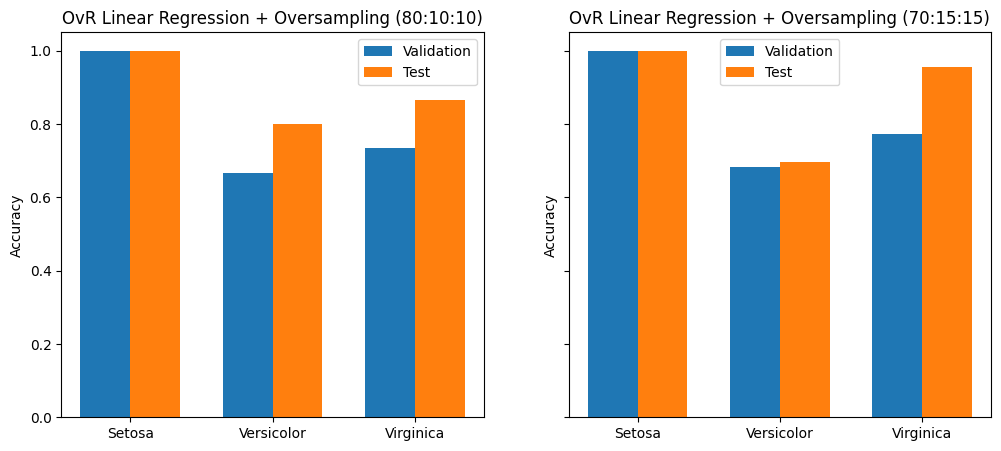

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target   # 0=setosa, 1=versicolor, 2=virginica
class_names = iris.target_names

# Helper: Random oversampling
# Helper: Random oversampling with info
def random_oversample(X, y):
    # Separate minority and majority
    X_minority = X[y == 1]
    X_majority = X[y == 0]

    n_minority = len(X_minority)
    n_majority = len(X_majority)

    print(f"Majority class size: {n_majority}, Minority class size: {n_minority}")

    # If already balanced, return
    if n_minority == n_majority:
        print("Dataset already balanced, no oversampling needed.")
        return X, y

    # How many samples need to be added to balance
    n_to_add = n_majority - n_minority
    print(f"Number of minority samples needed to balance: {n_to_add}")

    # Oversample minority
    oversampled_idx = np.random.choice(n_minority, size=n_to_add, replace=True)
    X_minority_oversampled = X_minority[oversampled_idx]
    y_minority_oversampled = np.ones(n_to_add, dtype=int)

    # Combine
    X_balanced = np.vstack((X_majority, X_minority, X_minority_oversampled))
    y_balanced = np.hstack((np.zeros(n_majority, dtype=int), y[y==1], y_minority_oversampled))

    # Shuffle
    idx = np.arange(len(y_balanced))
    np.random.shuffle(idx)

    return X_balanced[idx], y_balanced[idx]


# Function for One-vs-Rest linear regression with oversampling
def one_vs_rest_oversampled(X, y, target_class, split_type="80:10:10"):
    # Convert target to binary (OvR)
    y_binary = np.where(y == target_class, 1, 0)

    if split_type == "80:10:10":
        X_train, X_temp, y_train, y_temp = train_test_split(X, y_binary, test_size=0.2, random_state=42, stratify=y_binary)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

    elif split_type == "70:15:15":
        X_train, X_temp, y_train, y_temp = train_test_split(X, y_binary, test_size=0.3, random_state=42, stratify=y_binary)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

    # Oversample only on training set
    X_train, y_train = random_oversample(X_train, y_train)

    # Train linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predictions
    y_val_pred = (model.predict(X_val) >= 0.5).astype(int)
    y_test_pred = (model.predict(X_test) >= 0.5).astype(int)

    # Accuracy
    val_acc = accuracy_score(y_val, y_val_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    return val_acc, test_acc

# Run for each class
splits = ["80:10:10", "70:15:15"]
results = {split: [] for split in splits}

for split in splits:
    for target_class in range(3):
        val_acc, test_acc = one_vs_rest_oversampled(X, y, target_class, split_type=split)
        results[split].append((class_names[target_class], val_acc, test_acc))

# Print results
for split in splits:
    print(f"\n=== Oversampled Results for {split} split ===")
    for res in results[split]:
        print(f"Class {res[0]}: Validation Acc = {res[1]*100:.2f}%, Test Acc = {res[2]*100:.2f}%")

# Plot comparison
x_labels = ["Setosa", "Versicolor", "Virginica"]
x = np.arange(len(x_labels))
width = 0.35

fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for i, split in enumerate(splits):
    val_accs = [res[1] for res in results[split]]
    test_accs = [res[2] for res in results[split]]

    ax[i].bar(x - width/2, val_accs, width, label="Validation")
    ax[i].bar(x + width/2, test_accs, width, label="Test")
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(x_labels)
    ax[i].set_ylim(0, 1.05)
    ax[i].set_title(f"OvR Linear Regression + Oversampling ({split})")
    ax[i].set_ylabel("Accuracy")
    ax[i].legend()

plt.show()


In [3]:
import pandas as pd
from sklearn.datasets import load_iris

# Load iris dataset
iris = load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Create DataFrame
df = pd.DataFrame(X, columns=iris.feature_names)
df['species'] = y

# One-vs-Rest labelling
df['setosa_vs_rest'] = (df['species'] == 0).astype(int)      # Setosa = 1, others = 0
df['versicolor_vs_rest'] = (df['species'] == 1).astype(int)  # Versicolor = 1, others = 0
df['virginica_vs_rest'] = (df['species'] == 2).astype(int)   # Virginica = 1, others = 0

print(df.head(10))


   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   
5                5.4               3.9                1.7               0.4   
6                4.6               3.4                1.4               0.3   
7                5.0               3.4                1.5               0.2   
8                4.4               2.9                1.4               0.2   
9                4.9               3.1                1.5               0.1   

   species  setosa_vs_rest  versicolor_vs_rest  virginica_vs_rest  
0        0               1                   0                

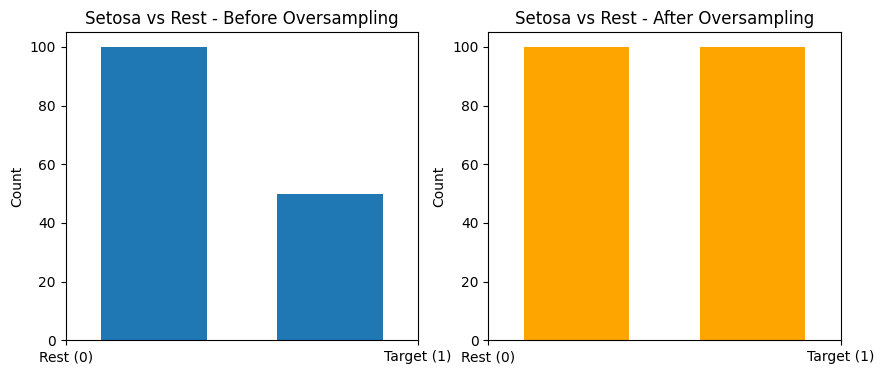


===== Setosa vs Rest =====
Accuracy: 1.0
Confusion Matrix:
 [[24  0]
 [ 0 16]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        16

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



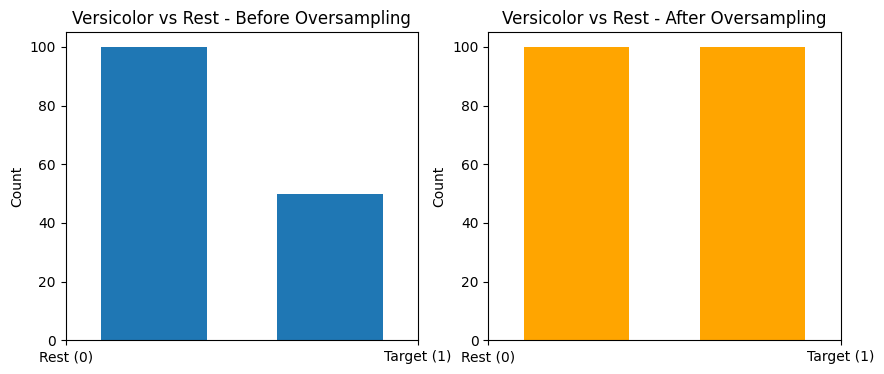


===== Versicolor vs Rest =====
Accuracy: 0.775
Confusion Matrix:
 [[11  4]
 [ 5 20]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.83      0.80      0.82        25

    accuracy                           0.78        40
   macro avg       0.76      0.77      0.76        40
weighted avg       0.78      0.78      0.78        40



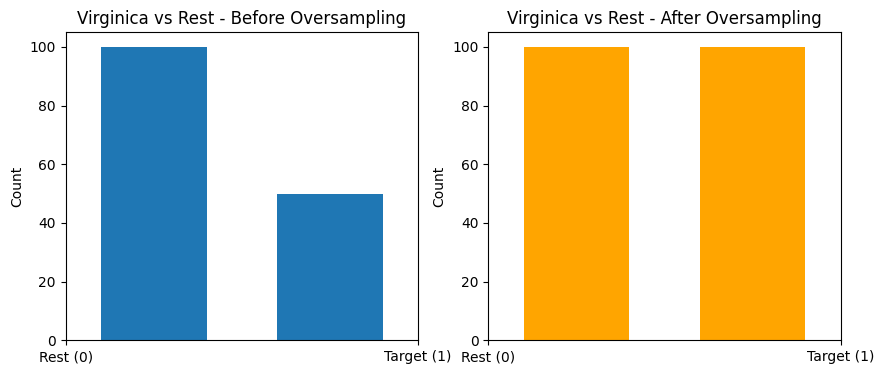


===== Virginica vs Rest =====
Accuracy: 0.9
Confusion Matrix:
 [[17  4]
 [ 0 19]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.81      0.89        21
           1       0.83      1.00      0.90        19

    accuracy                           0.90        40
   macro avg       0.91      0.90      0.90        40
weighted avg       0.92      0.90      0.90        40



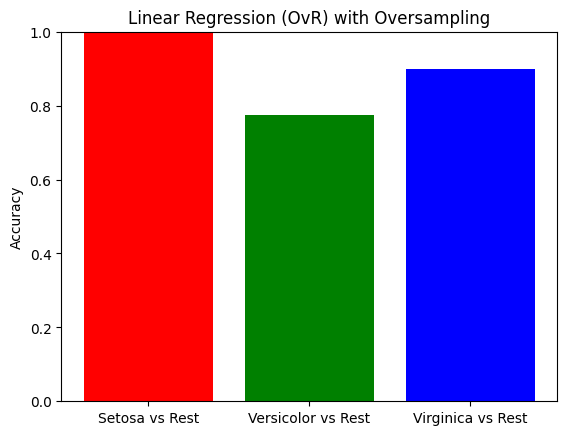

In [5]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

# Load dataset
iris = load_iris()
X = iris.data
y = iris.target

# DataFrame
df = pd.DataFrame(X, columns=iris.feature_names)
df['species'] = y

# Create One-vs-Rest labels
df['setosa_vs_rest'] = (df['species'] == 0).astype(int)
df['versicolor_vs_rest'] = (df['species'] == 1).astype(int)
df['virginica_vs_rest'] = (df['species'] == 2).astype(int)

# Function to oversample, train, and plot class distribution
def train_ovr_with_plot(X, y, label_name):
    # Plot class distribution before oversampling
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.hist(y, bins=2, rwidth=0.6)
    plt.title(f"{label_name} - Before Oversampling")
    plt.xticks([0,1], ["Rest (0)", "Target (1)"])
    plt.ylabel("Count")

    # Oversampling
    ros = RandomOverSampler(random_state=42)
    X_res, y_res = ros.fit_resample(X, y)

    # Plot class distribution after oversampling
    plt.subplot(1,2,2)
    plt.hist(y_res, bins=2, rwidth=0.6, color="orange")
    plt.title(f"{label_name} - After Oversampling")
    plt.xticks([0,1], ["Rest (0)", "Target (1)"])
    plt.ylabel("Count")
    plt.show()

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

    # Train linear regression
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_class = (y_pred >= 0.5).astype(int)  # threshold

    # Evaluation
    acc = accuracy_score(y_test, y_pred_class)
    print(f"\n===== {label_name} =====")
    print("Accuracy:", acc)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class))
    print("Classification Report:\n", classification_report(y_test, y_pred_class))

    return acc

# Run experiments
X_features = df[iris.feature_names]

acc_setosa = train_ovr_with_plot(X_features, df['setosa_vs_rest'], "Setosa vs Rest")
acc_versicolor = train_ovr_with_plot(X_features, df['versicolor_vs_rest'], "Versicolor vs Rest")
acc_virginica = train_ovr_with_plot(X_features, df['virginica_vs_rest'], "Virginica vs Rest")

# Compare results
labels = ["Setosa vs Rest", "Versicolor vs Rest", "Virginica vs Rest"]
accs = [acc_setosa, acc_versicolor, acc_virginica]

plt.bar(labels, accs, color=["red", "green", "blue"])
plt.title("Linear Regression (OvR) with Oversampling")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()


Minority class size before: 50
Majority class size: 100
Synthetic sample shape: (50, 4)
Balanced dataset size: (200, 4)


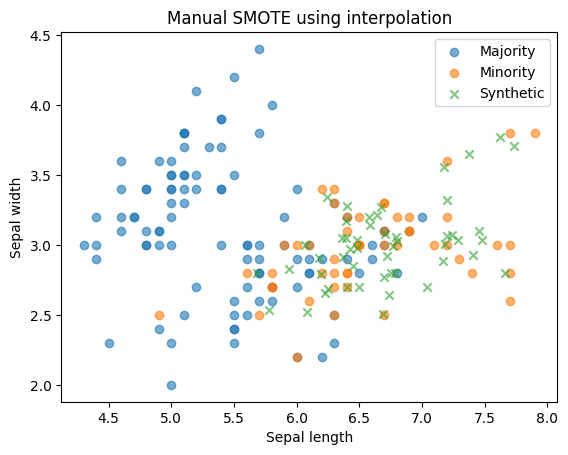

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

# Load dataset
iris = load_iris()
X = iris.data
y = iris.target

# Convert to DataFrame
df = pd.DataFrame(X, columns=iris.feature_names)
df['species'] = y

# One-vs-Rest: Example Virginica vs Rest
y_bin = (df['species'] == 2).astype(int)
X_minority = df[y_bin == 1][iris.feature_names].values
X_majority = df[y_bin == 0][iris.feature_names].values

print("Minority class size before:", len(X_minority))
print("Majority class size:", len(X_majority))

# Function to generate synthetic samples
def smote_manual(X_minority, n_new=50):
    synthetic = []
    n_samples = len(X_minority)
    for _ in range(n_new):
        # Pick 2 random minority samples
        i, j = np.random.choice(n_samples, 2, replace=False)
        x1, x2 = X_minority[i], X_minority[j]

        # Random lambda in [0,1]
        lam = np.random.rand()

        # Interpolation
        x_new = lam * x1 + (1 - lam) * x2
        synthetic.append(x_new)
    return np.array(synthetic)

# Generate synthetic samples
synthetic_samples = smote_manual(X_minority, n_new=50)

print("Synthetic sample shape:", synthetic_samples.shape)

# Combine original + synthetic
X_balanced = np.vstack([X_majority, X_minority, synthetic_samples])
y_balanced = np.hstack([
    np.zeros(len(X_majority)),
    np.ones(len(X_minority)),
    np.ones(len(synthetic_samples))
])

print("Balanced dataset size:", X_balanced.shape)

# Quick visualization (2D: sepal length vs sepal width)
plt.scatter(X_majority[:, 0], X_majority[:, 1], label="Majority", alpha=0.6)
plt.scatter(X_minority[:, 0], X_minority[:, 1], label="Minority", alpha=0.6)
plt.scatter(synthetic_samples[:, 0], synthetic_samples[:, 1],
            label="Synthetic", alpha=0.6, marker="x")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")
plt.legend()
plt.title("Manual SMOTE using interpolation")
plt.show()


using two samples from the minority class and generate the new synthetic
points.

Minority class size before: 50
Majority class size: 100
Synthetic sample shape (NN): (50, 4)
Balanced dataset size (NN): (200, 4)


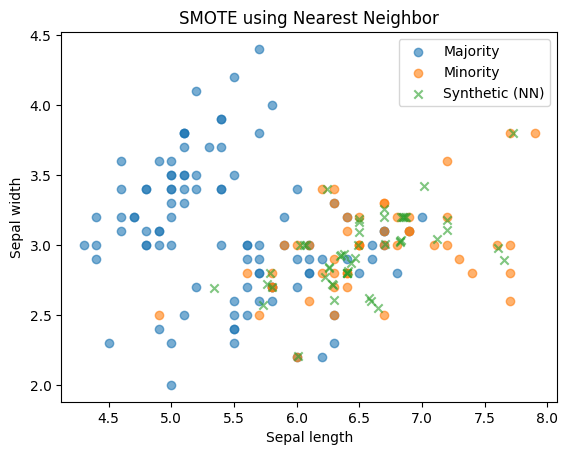

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from scipy.spatial import distance

# Load dataset
iris = load_iris()
X = iris.data
y = iris.target

# Convert to DataFrame
df = pd.DataFrame(X, columns=iris.feature_names)
df['species'] = y

# One-vs-Rest: Example Virginica vs Rest
y_bin = (df['species'] == 2).astype(int)
X_minority = df[y_bin == 1][iris.feature_names].values
X_majority = df[y_bin == 0][iris.feature_names].values

print("Minority class size before:", len(X_minority))
print("Majority class size:", len(X_majority))

# ------------------------------
# Part (b): SMOTE using nearest neighbor
# ------------------------------

def smote_nn(X_minority, n_new=50, k=1):
    """
    Generate synthetic minority samples using nearest neighbor approach.
    X_minority : array of minority samples
    n_new : number of synthetic samples to generate
    k : number of nearest neighbors to consider (default=1)
    """
    synthetic = []
    n_samples = len(X_minority)

    for _ in range(n_new):
        # Pick a random minority sample
        idx = np.random.randint(0, n_samples)
        x_i = X_minority[idx]

        # Compute distances to other minority samples
        dists = np.array([distance.euclidean(x_i, X_minority[j])
                          for j in range(n_samples)])
        dists[idx] = np.inf  # ignore self

        # Find nearest neighbor
        nn_idx = dists.argsort()[:k]
        nn_sample = X_minority[np.random.choice(nn_idx)]

        # Interpolation
        lam = np.random.rand()
        x_new = x_i + lam * (nn_sample - x_i)
        synthetic.append(x_new)

    return np.array(synthetic)

# Generate synthetic samples
synthetic_samples_nn = smote_nn(X_minority, n_new=50, k=1)
print("Synthetic sample shape (NN):", synthetic_samples_nn.shape)

# Combine original + synthetic
X_balanced_nn = np.vstack([X_majority, X_minority, synthetic_samples_nn])
y_balanced_nn = np.hstack([
    np.zeros(len(X_majority)),
    np.ones(len(X_minority)),
    np.ones(len(synthetic_samples_nn))
])

print("Balanced dataset size (NN):", X_balanced_nn.shape)

# Quick visualization (2D: sepal length vs sepal width)
plt.scatter(X_majority[:, 0], X_majority[:, 1], label="Majority", alpha=0.6)
plt.scatter(X_minority[:, 0], X_minority[:, 1], label="Minority", alpha=0.6)
plt.scatter(synthetic_samples_nn[:, 0], synthetic_samples_nn[:, 1],
            label="Synthetic (NN)", alpha=0.6, marker="x")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")
plt.legend()
plt.title("SMOTE using Nearest Neighbor")
plt.show()


SMOTE using k nearest neighbours wherek=1